In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 

import torch

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms
from torch.utils.data import  Dataset, TensorDataset, DataLoader


import lib.pytorch_trainer as ptt

from src.imgnet_utils import denormalize

from src.data_loader import _create_dataLoader

from src.Dataset import KaggleSafeDriverDataset

from src.plot_utils import (plot_classes, plot_distribution,
                            statistical_analysis_image, classDistribution,
                            plot_metrics,visualize_predictions,
                            plot_cm_train_valid,plot_layers_weight)
      
from src.convnet_models import (MyResNet, MyInception, MyDenseNet)

from src.extractor_utils import (predict, getPrediction,features_saving,features_loading)

from utils.utils import (create_submission ,metrics2csv, save_results)

In [2]:
print("{} GPU's available:".format(torch.cuda.device_count()) )
cpu_count = torch.multiprocessing.cpu_count()
print("\ncpu_count: {}".format(cpu_count))

4 GPU's available:

cpu_count: 24


In [3]:
use_gpu = torch.cuda.is_available()
use_DataParalel= True 
use_CPU= False        

if use_gpu:
    if use_DataParalel: 
        print("Using DataParalel in all {} GPUS".format(torch.cuda.device_count()))
    else:
        print('Using only one GPU') 
if use_CPU:         # http://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html 
    print("Using {} CPU's".format(cpu_count))

Using DataParalel in all 4 GPUS


In [4]:
if use_gpu:
    !free -h
    !nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:           220G         89G         38G        8.4G         93G        120G
Swap:            0B          0B          0B
Sun Nov 26 10:58:04 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00003609:00:00.0 Off |                    0 |
| N/A   63C    P0   111W / 149W |  10734MiB / 11439MiB |     50%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00004BDC:0


# Choose dataset 

In [5]:
path2train = "/mnt/home/e209440/data/train" 
path2test = "/mnt/home/e209440/data/test" 

path2features= "/mnt/home/e209440/state-farm-distracted-driver-detection/features/" 
#path2features= "/mnt/home/r120084/state-farm-distracted-driver-detection/features/" 

load_features = True

# Images transformation

In [6]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

img_width = img_height=300 #to use InceptionV3 it must img_width and img_height be changed to 300

# Data augmentation and normalization for training 
data_transforms = {
    'train': transforms.Compose([
        transforms.Scale((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        transforms.Scale((img_width, img_height)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}        

# Creating  Dataset & Dataloader

In [7]:
batch_size = 32
use_only = 1.0 # Use only is the percentage of the full dataset

In [31]:
dsets = {
    'train': KaggleSafeDriverDataset(path2train, transforms=data_transforms['train'],use_only=use_only),
    'valid': KaggleSafeDriverDataset(path2train, transforms=data_transforms['valid'],use_only=use_only, is_val=True, val_size=0.2),
    'test':  KaggleSafeDriverDataset(path2test, transforms=data_transforms['valid'],use_only=use_only, is_test=True),
}

In [25]:
dset_loaders = _create_dataLoader(dsets, batch_size, pin_memory=False, use_shuffle= True)

In [26]:
dset_sizes = {x: len(dsets[x]) for x in ['train','valid', 'test']} 
dset_classes = len(dsets['train'].y)
dset_classes, dset_sizes

# Dataset have much more samples than datatrain ***It comes from the test.zip****

(17940, {'test': 79726, 'train': 17940, 'valid': 4484})

# Checking GPU usage

In [88]:
!free -h
!nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:           220G         96G         31G        8.5G         93G        113G
Swap:            0B          0B          0B
Sun Nov 26 10:53:47 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00003609:00:00.0 Off |                    0 |
| N/A   63C    P0   136W / 149W |  11396MiB / 11439MiB |     98%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00004BDC:0

# Choosing Model

In [16]:
use_resnet = True
use_inception = False
use_denseNet = False

if use_resnet:
    print('Using ResNet model')
    model_name = "ResNet"
    model = MyResNet()
if use_inception:
    print('Using Inception model')
    model_name = "Inception"
    model = MyInception()
if use_denseNet:
    print('Using DenseNet model')
    model_name = "DenseNet"    
    model = MyDenseNet()

Using ResNet model


In [17]:
if use_gpu:
    if use_DataParalel:
        print("Using all GPU's ")
        model.mrnc = torch.nn.DataParallel(model.mrnc) #device_ids=[1,3]
        model.mrnc = model.mrnc.cuda()
        model.mrnd = torch.nn.DataParallel(model.mrnd) #device_ids=[1,3]
        model.mrnd = model.mrnd.cuda()
    else:
        print('Using GPU')# {}'.format(device_id))
        model.cuda()
        convnet = model.mrnc
        densenet = model.mrnd
else:
    print("Using CPU's")
    convnet = model.mrnc
    densenet = model.mrnd

Using all GPU's 


In [8]:
#print(model)

In [ ]:
#extract features from images
convOutput_train = predict(dset_loaders['train'], model.mrnc,use_gpu=use_gpu)
convOutput_valid = predict(dset_loaders['valid'], model.mrnc,use_gpu=use_gpu)
convOutput_test = predict(dset_loaders['test'], model.mrnc,use_gpu=use_gpu)

In [ ]:
print(convOutput_train['true'].size(), convOutput_train['pred'].size())
print(convOutput_valid['true'].size(), convOutput_valid['pred'].size())
print(convOutput_test['true'].size(), convOutput_test['pred'].size())

In [ ]:
print(convOutput_train['true'].type(), convOutput_train['pred'].type())

# Saving features

In [ ]:
sav_feats= {
    'train': (convOutput_train['pred'], convOutput_train['true'],model_name),
    'valid': (convOutput_valid['pred'], convOutput_valid['true'],model_name),
    'test': (convOutput_test['pred'], convOutput_test['true'],model_name)

}

In [ ]:
sav_feats['train'][2]

In [ ]:
features_saving(path2features,sav_feats)

# Loading features

In [8]:
model_name='ResNet'

In [9]:
load_feat= features_loading(path2features,model_name)

Loaded features with shapes: 


train:
pred torch.Size([17940, 6400]), true torch.Size([17940])

valid:
pred torch.Size([4484, 6400]), true torch.Size([4484])

test:
pred torch.Size([79726, 6400]), true torch.Size([79726])


In [10]:
load_feat['train'][0].shape,load_feat['train'][1].shape

(torch.Size([17940, 6400]), torch.Size([17940]))

In [18]:
if load_features:
    conv_dset ={
    'train': TensorDataset(load_feat['train'][0], load_feat['train'][1]),
    'valid': TensorDataset(load_feat['valid'][0], load_feat['valid'][1]),
    'test': TensorDataset(load_feat['test'][0], load_feat['test'][1])
    }
else:
    conv_dset ={
    'train': TensorDataset(convOutput_train['train'][0], convOutput_train['train'][1]),
    'valid': TensorDataset(convOutput_valid['valid'][0], convOutput_valid['valid'][1]),
    'test': TensorDataset(convOutput_test['test'][0], convOutput_test['test'][1])
    }

In [19]:
dset_loaders_convnet = _create_dataLoader(conv_dset, batch_size, 
                        pin_memory=False, use_shuffle= True)

In [20]:
dset_convnet_sizes = {x: len(dset_loaders_convnet[x]) for x in ['train','valid', 'test']} 
dset_convnet_sizes

{'test': 2492, 'train': 561, 'valid': 141}

In [21]:
path2saveModel = '/mnt/home/r120084/project/models/distractdriver'
#path2saveModel = '/mnt/home/e209440/models/ResNetDistractDriver' 

savebest = ptt.ModelCheckpoint(path2saveModel,reset=True, verbose=1)

In [22]:
loss_fn = nn.CrossEntropyLoss()
num_epochs = 50

optimizer =  optim.Adam(model.mrnd.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=5, gamma=0.75)

params = {'model' : model.mrnd, 
    'criterion': loss_fn,  
    'optimizer': optimizer, 
    'callbacks': [savebest, ptt.AccuracyMetric(), ptt.PrintCallback()] #ptt.PlotCallback(),
}

In [23]:
trainer = ptt.DeepNetTrainer(use_gpu=use_gpu,**params)

In [24]:
trainer.fit_loader(num_epochs, dset_loaders_convnet['train'], dset_loaders_convnet['valid'])

Start training for 50 epochs
  1: 162.8s   T: 1.64259 0.42196   V: 0.51759 0.85905 best
  2:  21.4s   T: 0.41191 0.86544   V: 0.16186 0.95807 best
  3:  20.5s   T: 0.22458 0.92698   V: 0.26461 0.90812 
  4:  20.5s   T: 0.15420 0.95106   V: 0.14292 0.95406 best
  5:  20.6s   T: 0.15175 0.95156   V: 0.13491 0.95852 best
  6:  20.6s   T: 0.13806 0.95713   V: 0.05668 0.98461 best
  7:  20.6s   T: 0.14084 0.95373   V: 0.06728 0.98260 
  8:  21.3s   T: 0.09092 0.96979   V: 0.05657 0.98149 best
  9:  21.1s   T: 0.09074 0.96984   V: 0.06742 0.97881 
 10:  21.1s   T: 0.08327 0.97352   V: 0.04918 0.98573 best
 11:  21.0s   T: 0.07541 0.97592   V: 0.20196 0.93510 
 12:  20.7s   T: 0.10704 0.96583   V: 0.08182 0.97480 
 13:  20.9s   T: 0.07770 0.97575   V: 0.02815 0.99130 best
 14:  20.7s   T: 0.08358 0.97280   V: 0.34558 0.88805 
 15:  20.7s   T: 0.04096 0.98612   V: 0.06870 0.97814 
 16:  20.8s   T: 0.05761 0.98088   V: 0.18569 0.94759 
 17:  20.3s   T: 0.06987 0.97809   V: 0.03469 0.99197 
 18:

# Loading best epoch

In [25]:
trainer.load_state(path2saveModel)
model.mrnd = trainer.model

In [26]:
!free -h
!nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:           220G         95G         32G        8.5G         93G        114G
Swap:            0B          0B          0B
Sun Nov 26 11:12:56 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00003609:00:00.0 Off |                    0 |
| N/A   63C    P0   143W / 149W |  11083MiB / 11439MiB |     20%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00004BDC:0

In [27]:
metrics2csv(trainer, 'ResNet18')

done!


In [28]:
train_eval = trainer.evaluate_loader(dset_loaders_convnet['train'])
valid_eval = trainer.evaluate_loader(dset_loaders_convnet['valid'])

evaluate: 560/560 ok
evaluate: 140/140 ok


In [29]:
train_eval, valid_eval

({'losses': 0.0028780445740989088}, {'losses': 0.01880508937759127})

In [32]:
# need to create a dataloader without shuffle to compare the mismatch
dset_loaders_wshuffle = _create_dataLoader(dsets, batch_size, pin_memory=False, use_shuffle= False)

In [33]:
#we need to use all dloader, because this one has use_shuffle false
result_train = predict(dset_loaders_wshuffle['train'], model, use_gpu=use_gpu)
result_valid = predict(dset_loaders_wshuffle['valid'], model, use_gpu=use_gpu)
result_test = predict(dset_loaders_wshuffle['test'], model, use_gpu=use_gpu)

predict: 560/560 ok
predict: 140/140 ok
predict: 2491/2491 ok


In [37]:
predictions_out = {'train': result_train, 'valid': result_valid, 'test': result_test}

In [61]:
save_results(predictions_out, 'Resnet18')

Save result from train set done!
Save result from valid set done!
Save result from test set done!


In [62]:
result_train = getPrediction(result_train)
result_valid = getPrediction(result_valid)
# result_test['pred'] must be an array of probabilities to make the submission

In [63]:
correct_train = (result_train['true'] == result_train['pred']).sum()
correct_valid = (result_valid['true'] == result_valid['pred']).sum()

In [64]:
print('Train: ', correct_train, '/', len(dsets['train']) )
print('Valid: ', correct_valid, '/', len(dsets['valid']) )

Train:  17926 / 17940
Valid:  4462 / 4484


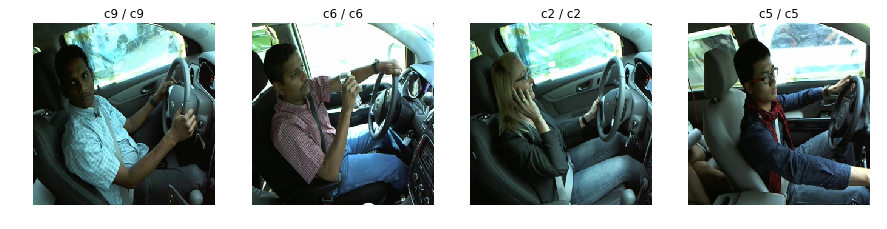

In [65]:
visualize_predictions(dsets['valid'], result_valid, correct_pred = True)

In [ ]:
#move this to Data Visualization
#visualize_predictions(dsets['valid'], result_valid, correct_pred = False)

In [ ]:
#plot_cm_train_valid(result_train,result_valid)

In [ ]:
#move this to Data Visualization
#plot_layers_weight(dsets,img_width=img_width, img_height=img_height,conv_model = model.mrnc,use_gpu=use_gpu)

# Make submission of the Test set

In [ ]:
create_submission(result_test, 'distracted_driver')